# Rain Event Finder--Concrete (Fast Version)
The purpose of this notebook is to very quickly find rain events from a csv file, and plot the flow versus rainfall. This version will be very hard to debug, but it's offset by how quick it will be. Load the cell below.
To load a cell, hold "shift" and press "return" or "Enter"

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 1000)

Import the proper csv file. Make sure that the data file in URL agrees with the name below

In [2]:
df = pd.read_csv('2019-2020 concrete vs rain.csv')

Now load the following cell.

In [2]:
def rename_one_column(old_column_name, new_column_name):
    """Renames one column of the df dataframe.
    old_column_name : the bolded name that you wish to change
    new_column_name : the name that you wish to replace the old label with
    
    Returns none. Simply modifies the df.
    """
    column_names = df.columns.tolist()
    for i in range(len(column_names)):
        if column_names[i] == old_column_name:
            column_names[i] = new_column_name
            df.columns = column_names
            return
    print("No column was found with the given name: " + old_column_name)
    print("These are the current column names: ")
    print(df.columns.tolist())
rename_one_column('Unnamed: 0', 'Rain')
rename_one_column('TOA5 idea concrete cr 1000', 'Date/Time')
rename_one_column('CPU:Concrete_20190329.CR1', 'CnoC')
rename_one_column('430', 'CC')
def specify_data(*args):
    """Removes unwanted columns from the df dataframe. 
    *args : a variable number of arguments. They must be in quotes and separated by commas
    
    Returns the modified dataframe.
    Valid calls:
    >>> specify_data('Hello')
    >>> specify_data('Column 1', 'Column 2', 'Column 3')
    
    """
    columns_to_keep = []
    for col in args:
        columns_to_keep += [col]
    try:
        df1 = df[columns_to_keep]
    except Exception as e:
        print(e)
        print("The column names are: ")
        print(df.columns.tolist())
        print("Please run the cell again.")
        return df
    df1 = df[columns_to_keep]
    return df1

def remove_rows(*args):
    """Removes rows from the dataframe df
    
    *args : a variable number of arguments. Must be positive integers, separated by commmas. DO NOT USE QUOTES.
    
    Valid calls:
    >>>remove_rows(1, 2, 3)
    >>>remove_rows(0)
    >>>remove_rows(72)
    
    Returns the modified dataframe.
    """
    row_names = list(args)
    try:
        df1 = df.drop(df.index[row_names])
    except Exception as e:
        print(e)
        print('The most likely error is that there is no row with the given label. Make sure not to use quotes with row labels, just numbers')
    df1 = df.drop(df.index[row_names])
    return df1
df = specify_data('Rain', 'Date/Time', 'CnoC', 'CC')
df = remove_rows(0, 1, 2)
df = df.dropna()
df = df.reset_index()
df = df.drop("index", axis = 1)
def reformat(date_column = "DEFAULT"):
    """Reformats the strings in the table to be floats.
    date_column : the name (string) of the column of df that contains date information.

    Returns none. Modifies df.
    """
    if date_column == "DEFAULT":
        for col in df.columns:
            df[col] = df[col].astype(float)
    else:
        columns = df.columns.tolist()
        columns.remove(date_column)
        for col in columns:
            df[col] = df[col].astype(float)
reformat('Date/Time')
def convert_to_mm(rain_column):
    """Converts in into mm.
    rain_column : the name of the column that contains rain data (should be in mm)
    
    Returns the modified dataframe.
    """
    df[rain_column] = df[rain_column].multiply(25.4)
    df1 = df
    return df
df = convert_to_mm('Rain')
def find_rain_event(rain_column, date_column, gap=72, min_rain = 3.81):
    """
    Finds rain events, which are defined by rain of at least .15 inches, with gaps less than six hours.
    rain_column : the name of the column that contains rain data
    date_column : the name of the column that contains date data
    gap : the gap after which, with no rain, a rain event ends. Because the table has intervals of 5 min,
          gap is set by default to 72 (5 * 72 = 360 minutes = 6 hours)
    min_rain : the minimum rain required for a rain event. Set to .15, in inches
    
    
    Returns a dataframe of rain events with the start date, end date, amount of rain, and flow through each raingarden.
    """
    start_index = 0
    curr_index = 0
    rain_total = 0
    curr_gap = 0
    rain_event_found = False
    old_columns = df.columns.tolist()
    old_columns.remove(date_column)
    new_columns = ["Start Date", "End Date"] + old_columns
    total_df = pd.DataFrame(columns = new_columns)
    while curr_index < len(df.index):
        current_rain = df.at[curr_index, rain_column]
        if rain_total >= min_rain:
            if curr_gap == gap:
                #We've found the end of our rain event
                #Add sums to the total_df
                event_only_df = pd.DataFrame(columns = df.columns)
                event_only_df = event_only_df.append(df.loc[start_index : curr_index + 1, : ])
                sums = event_only_df.sum()
                for col in sums.index:
                    if col != rain_column and col != date_column:
                        sums[col] *= 5
                sums = sums.drop(labels = [date_column])
                start_date = df.at[start_index, date_column]
                end_date = df.at[curr_index, date_column]
                event_values = [start_date, end_date] + sums.tolist()
                series_index = new_columns
                event_series = pd.Series(event_values, index = series_index)
                total_df = total_df.append(event_series, ignore_index = True)
                #Reset values to continue looping
                rain_event_found = False
                rain_total = 0
                curr_gap = 0
                curr_index += 1
            elif curr_gap < gap:
                if current_rain == 0:
                    curr_gap += 1
                else:
                    curr_gap = 0
                    rain_total += current_rain
                curr_index += 1
            #We don't have to worry about curr_gap being larger than the gap, because the boolean case checks if the
            #curr_gap is equal to gap.
        else:
            if rain_event_found:
                if curr_gap < gap:
                    if current_rain == 0:
                        curr_gap += 1
                    else:
                        curr_gap = 0
                    curr_index += 1
                    rain_total += current_rain
                elif curr_gap == gap:
                    #We've reached the six hour mark and the rainfall is less than .15. We just need to move on.
                    rain_event_found = False
                    rain_total = 0
                    curr_gap = 0
                    curr_index += 1
            else:
                if current_rain == 0:
                    curr_index += 1
                else:
                    rain_event_found = True
                    start_index = curr_index
                    rain_total += current_rain
                    curr_index += 1
    return total_df
final_df = find_rain_event('Rain', 'Date/Time')
#I have already set one bad value to be the rain event on the 12th of december for AnoC.
#The offsets were changed for CnoC on the 16th, so I assumed that the values would be more reliable afterwards.
#Note: I would consider starting from scratch for CnoC, but I removed the values where there was
# Clearly flow in CC and not in CnoC
bad_values = {'CnoC':[16, 22, 23, 26, 27], 'CC':[]}
for key in bad_values:
    for row_number in bad_values[key]:
        final_df.at[row_number, key] = np.nan

        
def add_bad_value(column_name, row_number):
    """Adds dates to the bad_value dictionary.
    column_name : the name of the rain garden you wish to note a bad value. Use quotes.
    row_number : row that contains the rain event that is a bad data point. Do not use quotes.
    
    Returns none.
    #The following line would make sure that the rain event at row 0 for raingarden 101 will NOT be graphed.
    >>> add_bad_value('101', 0)
    """
    try:
        final_df.at[row_number, column_name] = np.nan
    except Exception as e:
        print(e)
        print("The most likely error is you passed in a column name or row number that does not exist.")
    bad_values[column_name] += [row_number]
    final_df.at[row_number, column_name] = np.nan

def reset_bad_value(column_name, row_number, value):
    """Resets a value. If you accidentally set a data point to a bad value, this function will reset it. In order to get
    that previous bad value, check the rain event table above the pruning section.
    
    column_name : the name of the column that contains the value you are trying to reset. Use quotes.
    row_number : the row number that contains the value you are trying to reset. Do not use quotes.
    value : the value you wish to replace NaN with. Do not use quotes.
    Returns none.
    
    The following line will reset row 0, column 101's value to 13.
    >>>reset_bad_value('101', 0, 13)
    """
    try:
        final_df.at[row_number, column_name] = value
    except Exception as e:
        print(e)
        print("The most likely error is you passed in a column name or row number that does not exist.")
    final_df.at[row_number, column_name] = value
def remove_rows_final(*args):
    """Removes rows from the dataframe final_df
    
    *args : a variable number of arguments. Must be positive integers, separated by commmas. DO NOT USE QUOTES.
    
    Valid calls:
    >>>remove_rows_final(1, 2, 3)
    >>>remove_rows_final(0)
    >>>remove_rows_final(72)
    
    Returns the modified dataframe.
    """
    row_names = list(args)
    try:
        df1 = final_df.drop(df.index[row_names])
    except Exception as e:
        print(e)
        print('The most likely error is that there is no row with the given label. Make sure not to use quotes with row labels, just numbers')
    df1 = final_df.drop(df.index[row_names])
    df1 = df1.reset_index()
    df1 = df1.drop("index", axis = 1)
    return df1
final_df = remove_rows_final(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
def graph(rain, garden_number, text_x = 130, text_y = 0):
    """Graphs a single raingarden's flow vs rainfall.
    rain : the name of the column that contains rain data
    garden_number :  the name of thec column that contains the raingarden whose data you wish to graph.
    text_x : the default x-coordinate of the regression equation
    text_y = 0 : the default y-coordinate of the regression equation
    
    Returns: none
    
    """
    garden_series = final_df[garden_number]
    rain_series = final_df[rain]
    for i in range(len(garden_series)):
        if garden_series.get(i) != garden_series.get(i):
            garden_series = garden_series.drop(labels=[i])
            rain_series = rain_series.drop(labels=[i])
            #get rid of the last three values because they're just stats
    garden_series = garden_series[:len(garden_series) -3]
    rain_series = rain_series[:len(rain_series) - 3]
    
    m, b = np.polyfit(rain_series, garden_series, 1)
    m = '%.3f'%(m)
    b = '%.3f'%(b)
    eq = 'y = ' + str(m) + 'x + ' + str(b)
    title = garden_number + ' Flow Output (L) vs Rain (mm)'
    plot = sns.regplot(x=rain,y=garden_number,data=final_df,fit_reg=True)
    plot.text(text_x, text_y, eq, horizontalalignment='left', size='large', color='black')
    plot.set_title(title)
    plt.show()
def calculate_stat(rain_column):
    garden_columns = final_df.columns[3:]
    slope_list = [np.nan, np.nan, np.nan]
    r_list = [np.nan, np.nan, np.nan]
    p_list = [np.nan, np.nan, np.nan]
    for garden_number in garden_columns:
        garden_series = final_df[garden_number]
        rain_series = final_df[rain_column]
        for i in range(len(garden_series)):
            if np.isnan(garden_series.get(i)):
                garden_series = garden_series.drop(labels=[i])
                rain_series = rain_series.drop(labels=[i])
        m = sp.stats.linregress(rain_series, garden_series)[0]
        r = sp.stats.linregress(rain_series, garden_series)[2]
        p_val = sp.stats.linregress(rain_series, garden_series)[3]
        slope_list.append(m)
        r_list.append(r)
        p_list.append(p_val)
    slope_series, r_series, p_series = pd.Series(slope_list, final_df.columns, name = 'Slopes'), pd.Series(r_list, final_df.columns, name='R values'), pd.Series(p_list, final_df.columns, name='P values')
    df1 = final_df.append(slope_series)
    df1 = df1.append(r_series)
    df1 = df1.append(p_series)    
    return df1
final_df = calculate_stat('Rain')
pd.set_option('display.max_rows', len(final_df.index))
final_df

NameError: name 'df' is not defined

Run the following cell to export the table. This table contains the total rainfall of each rain event (in inches), the start and end date of each rain event, and the total flow through each raingarden (in gallons). Replace 'concrete_rain_events.csv' with whatever name you wish the file to be. It will appear in URL. Make sure your file name contains .csv at the end.
Note: bad data values will appear as NaN in the table.

In [1]:
final_df.to_csv('concrete_rain_events.csv', index=False)

NameError: name 'final_df' is not defined

Run the cell below to graph the rain events. Replace 'Rain' with the column name containing rain data, and 'CnoC' with the columnn name containing AnoC flow data. Make sure to use quotes.
If you wish to move the regression equation around, simply provide two additional arguments to the graph function, the x and y coordinates of the new location for the label. For example:
<p>graph('Rain', 'CnoC', 0, 0)</p>
<p>would place the regression equation at the origin of the graph.</p>

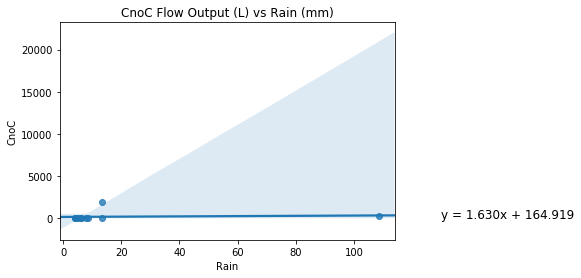

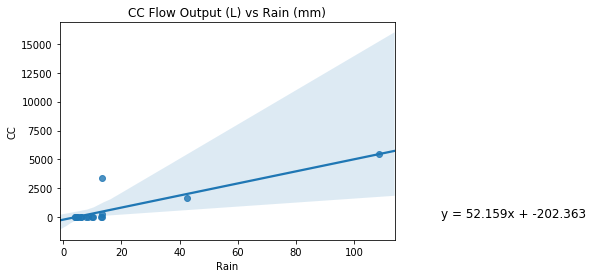

In [5]:
graph('Rain', 'CnoC')
graph('Rain', 'CC')